### Step 1: download pregenerated dataset from iNaturalist as follows:

1. Go to iNaturalist.org and sign into your account.
2. Go to observations > export and create a Query with the following criteria in the following fields:

    Filter: quality grade Research
    
    Place: DMV, US
    
    Taxon: Apis mellifera
    
3. Create export

### Step 2: import necessary packages and functions

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

### Step 3: unzip and upload dataset to project folder

Import dataset

In [3]:
iNat_monitor = pd.read_csv('observations-71449.csv', header=0, parse_dates=True, squeeze=True)

In [4]:
# check first rows
iNat_monitor.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,out_of_range,user_id,user_login,created_at,updated_at,...,geoprivacy,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,330317,4/26/2013 12:10,4/26/2013,2013-04-26 16:10:28 UTC,Eastern Time (US & Canada),NaN,14389,sdroege,2013-07-12 19:32:49 UTC,2017-11-09 19:02:58 UTC,...,NaN,NaN,False,NaN,NaN,Honey Bee,Apis mellifera,Western Honey Bee,Insecta,47219
1,330329,4/25/2013 17:25,4/25/2013,2013-04-25 21:25:16 UTC,Eastern Time (US & Canada),NaN,14389,sdroege,2013-07-12 19:38:12 UTC,2017-11-09 19:03:00 UTC,...,NaN,NaN,False,NaN,NaN,Honey Bee,Apis mellifera,Western Honey Bee,Insecta,47219
2,534926,9/22/2012 10:16,9/22/2012,2012-09-22 14:16:01 UTC,Eastern Time (US & Canada),NaN,30601,calopteryx,2014-02-18 04:55:08 UTC,2017-11-09 19:24:06 UTC,...,NaN,NaN,False,NaN,NaN,Apis mellifera,Apis mellifera,Western Honey Bee,Insecta,47219
3,548320,6/11/2013 6:20,6/11/2013,2013-06-11 10:20:18 UTC,Eastern Time (US & Canada),NaN,30601,calopteryx,2014-03-02 04:21:14 UTC,2017-11-09 19:26:51 UTC,...,NaN,NaN,False,NaN,NaN,Apis mellifera,Apis mellifera,Western Honey Bee,Insecta,47219
4,775199,7/8/2014 18:00,7/8/2014,2014-07-08 22:00:00 UTC,Eastern Time (US & Canada),NaN,31092,ecologyelise,2014-07-08 22:25:03 UTC,2018-12-12 06:28:44 UTC,...,obscured,NaN,True,NaN,NaN,Western Honey Bee,Apis mellifera,Western Honey Bee,Insecta,47219


### Step 4: Create season variable 

In [5]:
# Convert pandas series to dataframe and observed_on to datetime64
df_iNat = pd.DataFrame({'observed_on':iNat_monitor.observed_on, 'user_id':iNat_monitor.user_id})
df_iNat["observed_on"] = df_iNat["observed_on"].astype("datetime64")

# Observation count variable
df_iNat['count'] = 1

print(df_iNat.head())

  observed_on  user_id  count
0  2013-04-26    14389      1
1  2013-04-25    14389      1
2  2012-09-22    30601      1
3  2013-06-11    30601      1
4  2014-07-08    31092      1


In [6]:
# Convert observed_on to string
df_iNat['observed_on'] = df_iNat.observed_on.astype(str)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


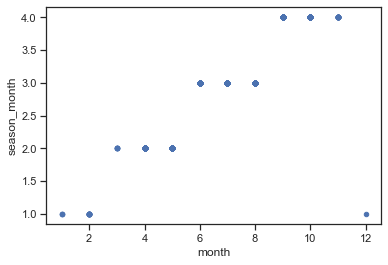

In [7]:
# Create season variable as new_month (1 for Dec-Feb, 2 for Mar-May, 3 for Jun-Aug, 4 for Sep-Nov)
df_iNat['month'] = df_iNat.observed_on.str.slice(start=5, stop=7).astype(int)
df_iNat['season_month'] = df_iNat.month.apply(lambda x: (x%12 + 3)//3)

# Check that the above operation produces plausible results
assert df_iNat.season_month.all() > 0
assert df_iNat.season_month.all() <= 4

# Visual check (will print if assert statements don't give an error)
df_iNat.plot.scatter(x='month',y='season_month')

In [8]:
# now rename to season names
df_iNat.loc[df_iNat['season_month'] ==2, 'season'] = 'spring'
df_iNat.loc[df_iNat['season_month'] ==3, 'season'] = 'summer'
df_iNat.loc[df_iNat['season_month'] ==4, 'season'] = 'fall'
df_iNat.loc[df_iNat['season_month'] ==1, 'season'] = 'winter'

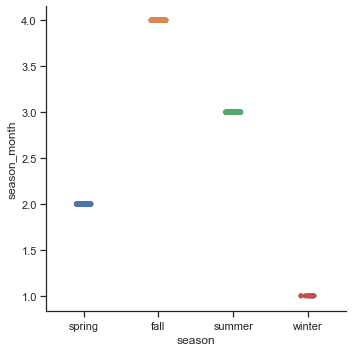

In [9]:
# check that 2 corresponds to spring, 3 to summer, 4 to fall, 1 to winter
sns.catplot(x="season", y="season_month", data=df_iNat)

In [10]:
# Get a variable for year
df_iNat['year'] = df_iNat.observed_on.str.slice(0,4)

# Check dataframe format
print(df_iNat.head())

  observed_on  user_id  count  month  season_month  season  year
0  2013-04-26    14389      1      4             2  spring  2013
1  2013-04-25    14389      1      4             2  spring  2013
2  2012-09-22    30601      1      9             4    fall  2012
3  2013-06-11    30601      1      6             3  summer  2013
4  2014-07-08    31092      1      7             3  summer  2014


### Step 5: Adjust number of observations by number of users

In [11]:
# Sum observations (count) by season (using season_month) and year
df_iNat['obs_perseason'] = df_iNat.groupby(['year', 'season_month'])['count'].transform('sum')

# Count of unique values for user_id (number of users) per season, year
df_iNat['user_count'] = df_iNat.groupby(['year', 'season_month'])['user_id'].transform('nunique')

# Check that user count is above zero (and no missings) to avoid division by zero in next cell
assert df_iNat['user_count'].all() > 0
assert df_iNat['user_count'].all() != 'NaN'

In [12]:
# Create variable for adusted observations (observations per number of iNaturalist observers at each time point)
df_iNat['adj_obs'] = (df_iNat['obs_perseason']/df_iNat['user_count'])


### Step 6: manipulate dataframe (prepare for creating graph)

First, keep only unique values (condense into one row per season, year)

In [13]:
iNat_complete = df_iNat.drop_duplicates(subset=['year','season_month'], keep='first')

Then, order by date (observed_on)

In [14]:
# Now that we don't have repeated rows for the same date, we can order by date
iNat_complete = iNat_complete.sort_values(by='observed_on')

Concatenate season and year variables

In [15]:
iNat_complete['season_year'] = iNat_complete['season'] + ', ' + iNat_complete['year']

# Make new index in next step
iNat_complete = iNat_complete.reset_index(drop=True)

Drop columns not needed, rename variables for graph labels

In [16]:
# New dataframe only with columns needed
iNat_complete = pd.DataFrame({'season_year':iNat_complete.season_year, 'obs_perseason':iNat_complete.obs_perseason,'adj_obs':iNat_complete.adj_obs})
iNat_complete = iNat_complete.rename(columns={"season_year":"Date of observation","obs_perseason":"Number of observations","adj_obs":"Observations per user"})

# Check final dataset for graphs
iNat_complete

,Date of observation,Number of observations,Observations per user
0,"summer, 2005",3,3.000000
1,"summer, 2006",1,1.000000
2,"spring, 2010",1,1.000000
3,"fall, 2010",1,1.000000
4,"summer, 2011",1,1.000000
5,"fall, 2011",2,1.000000
6,"spring, 2012",1,1.000000
7,"summer, 2012",1,1.000000
8,"fall, 2012",2,1.000000
9,"spring, 2013",2,2.000000


### Step 7: undadjusted graph

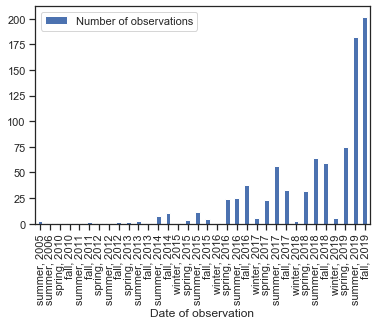

In [25]:
iNat_graph = iNat_complete.plot.bar(x='Date of observation', y='Number of observations', rot=90).get_figure()
# Save figure
iNat_graph.savefig('unadjusted_observations.pdf',dpi=300, bbox_inches = "tight")

This graph shows a sharp increase in observations of honeybees in the DMV area. 
There is a seasonal pattern, where they are observed the most in spring, summer, and fall.
However, this graph, more than showing the presence of honeybees in the area, reflects the increase of iNaturalist users in time.
the project of iNaturalist launched in 2008, with the possibility to enter observations retrospectively, 
hence the presence of a few observations before then.

### Step 8: user-adjusted graph

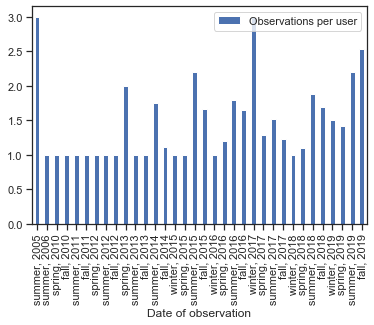

In [26]:
iNat_graph_adjusted = iNat_complete.plot.bar(x='Date of observation', y='Observations per user', rot=90).get_figure()
# Save figure
iNat_graph_adjusted.savefig('adjusted_observations.pdf', dpi=300, bbox_inches = "tight")

This graph shows the number of observations per iNaturalist user. 
It shows peaks of observations on spring, summer, and fall, with the exception of winter 2017, 
when there were 3 observations per iNaturalist user.
In general, this graph does not reflect a decline of observations in time. 
Perhaps in the next few years, with a higherer number of iNaturalists and increased habitat threat 
of pollinators from worsening climate change, we will see a downward trend.

### Step 9: update git

In [29]:
# update git
!git add DMV_bees.ipynb
!git add README.md
!git commit -m "add details about saving the resulting graphs"

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[master c249eba] add details about saving the resulting graphs
 Committer: Schwedhelm <schwedhelmramc2@nih.gov>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly. Run the
following command and follow the instructions in your editor to edit
your configuration file:

    git config --global --edit

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 2 files changed, 9 insertions(+), 7 deletions(-)


In [30]:
!git push

To https://github.com/caroschwedh/BIOF309-final-project.git
   0ad9b82..c249eba  master -> master
